# **Problem Definition**

The problem I'm going to address is **forecasting the amount of courier partners that will go online the following days**.

# **Data Collection**

**TLDR:** Dataset fetched from github, contains time-series data having five features including **dates, courier partners online, temperature, humidity and precipitation**

In [ ]:
!wget https://raw.githubusercontent.com/woltapp/data-science-internship-2024/main/daily_cp_activity_dataset.csv

--2024-01-31 03:18:28--  https://raw.githubusercontent.com/woltapp/data-science-internship-2024/main/daily_cp_activity_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22068 (22K) [text/plain]
Saving to: ‘daily_cp_activity_dataset.csv.4’

daily_cp_activity_d 100%[===================>]  21.55K  --.-KB/s    in 0.001s  

2024-01-31 03:18:28 (26.5 MB/s) - ‘daily_cp_activity_dataset.csv.4’ saved [22068/22068]



In [ ]:
import pandas as pd

# Load the data
path = 'daily_cp_activity_dataset.csv'
data = pd.read_csv(path)

# Display basic info and first few rows of the dataset
data.head()

,date,courier_partners_online,temperature,relative_humidity,precipitation
0,2021-05-01,49,18.27,0.57,0.0
1,2021-05-02,927,19.88,0.55,0.0
2,2021-05-03,40,16.88,0.60,0.0
3,2021-05-04,51,21.88,0.53,0.0
4,2021-05-05,50,21.11,0.54,0.0


In [ ]:
# Before working with dates, first convert the 'date' column to datetime format and set it as the index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# **Data Cleaning**

**TLDR:** Data contained missing values but no duplicates or invalidation.

## **1. Missing values**
Finding any null or NaN values.

In [ ]:
data.isnull().sum()

courier_partners_online     0
temperature                30
relative_humidity           0
precipitation               5
dtype: int64

We notice that we found **30 temperature** and **5 precipitation** missing values.

In [ ]:
data.shape

(761, 4)

Since our total numbers of rows are only **761**, we should try to find impute these missing values using median values. This is okay as the temperature and precipitation remains consistent across several days under normal circumstances.

In [ ]:
data['temperature'] = data['temperature'].fillna(data['temperature'].median())
data['precipitation'] = data['precipitation'].fillna(data['precipitation'].median())

In [ ]:
data.isnull().sum()

courier_partners_online    0
temperature                0
relative_humidity          0
precipitation              0
dtype: int64

## **2. Duplicate data removal**

As a safety measure, we'll drop any duplicate rows found.

In [ ]:
data = data.drop_duplicates()

In [ ]:
data.shape

(757, 4)

**No duplicates** were found in our dataset.

## **3. Data validation**

For **temperature**, we'll consider unrealistic values to be beyond the highest and lowest temperatures recorded on Earth (approximately -89.2°C to 56.7°C).

For **precipitation**, relative humidity, and courier partners online, we'll ensure these values are not negative.

In [ ]:
# Validate temperature range
data = data[(data['temperature'] >= -89.2) & (data['temperature'] <= 56.7)]
print("Data after temp validation", data.shape)

# Ensure non-negative values for precipitation, relative humidity, and courier partners online
data_cleaned = data[(data['precipitation'] >= 0) & (data['relative_humidity'] >= 0) & (data['courier_partners_online'] >= 0)]
print("Data after other non-negative features", data.shape)

Data after temp validation (757, 4)
Data after other non-negative features (757, 4)


Luckily, we **didn't have inconsistency** in our data so we're good to proceed.

# **Exploratory Data Analysis (EDA)**

**TLDR:** Relationships seems non-linear suggesting the use of non-linear models

## **1. Statistical Summary**
Analysis of distribution, central tendency (mean, median), and dispersion (variance, standard deviation).

In [ ]:
# Displaying summary statistics and info
data_info = data.describe()
data_types = data.dtypes

data_info, data_types

(       courier_partners_online  temperature  relative_humidity  precipitation
 count               757.000000   757.000000         757.000000      757.00000
 mean                 72.425363    17.556367           0.653514        0.91255
 std                  96.293265     9.813095           0.171559        1.74945
 min                  34.000000    -9.980000           0.430000        0.00000
 25%                  58.000000    11.320000           0.520000        0.00000
 50%                  66.000000    18.630000           0.590000        0.00000
 75%                  72.000000    24.020000           0.790000        0.91000
 max                1506.000000    37.950000           1.000000       12.90000,
 courier_partners_online      int64
 temperature                float64
 relative_humidity          float64
 precipitation              float64
 dtype: object)

**Online Courier Partners** has a mean of approximately 72.42, with a standard deviation of 96.04, indicating **significant variability** in the daily number of courier partners online. The minimum value 34 and maximum value 1506 suggests **some outliers or exceptional days** with very high activity.

Temperature, relative humidity, and precipitation columns are consistent with typical weather data range.

## **2. Univariate Analysis**

Analysis involving only one variable, useful for spotting **outliers and skewness**.

### **Histogram Plot**

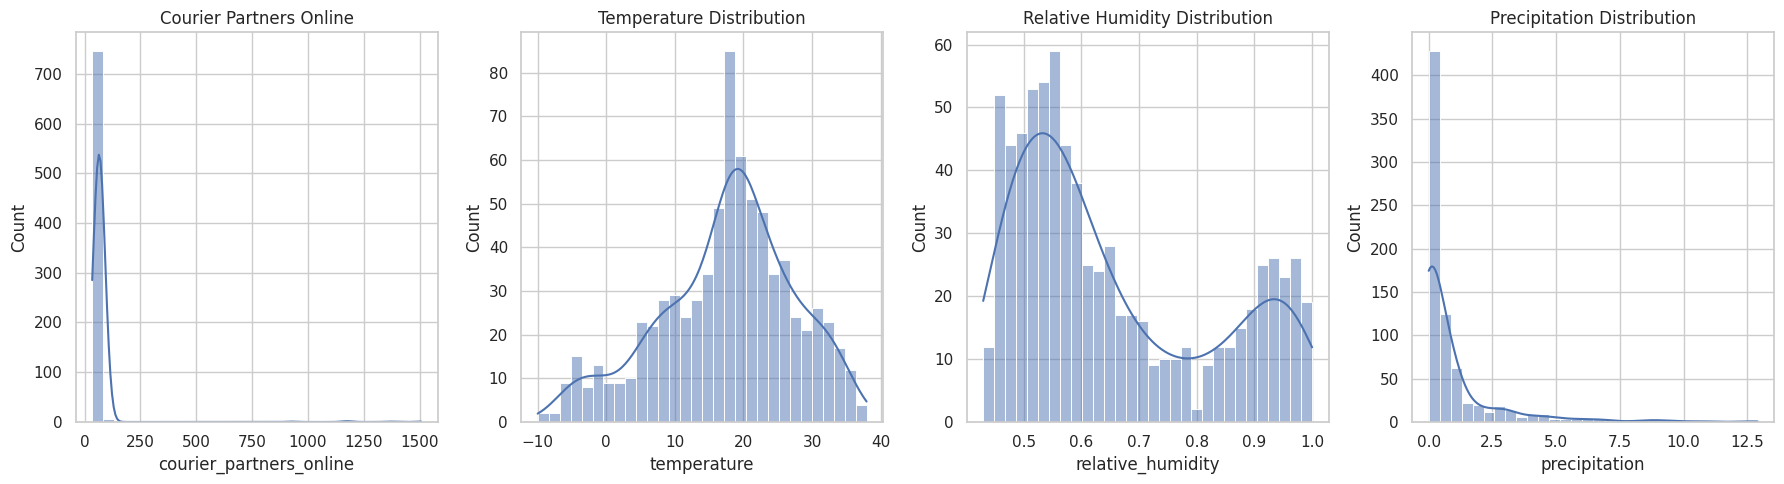

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Plot histograms for numerical features
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

sns.histplot(data['courier_partners_online'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Courier Partners Online')

sns.histplot(data['temperature'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Temperature Distribution')

sns.histplot(data['relative_humidity'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Relative Humidity Distribution')

sns.histplot(data['precipitation'], bins=30, kde=True, ax=axes[3])
axes[3].set_title('Precipitation Distribution')

plt.tight_layout()
plt.show()

**Courier Partners Online:** This histogram shows a** highly skewed distribution** where the majority of the counts are close to 0. This suggests that most of the time, there are very few courier partners online, with the counts rapidly decreasing as the number of online partners increases.

**Temperature Distribution:** This histogram appears to follow a **somewhat normal distributio**n with a slight right skew. The temperature is most frequently observed in the range around 10 to 20 degrees, which could suggest a temperate climate. The presence of temperatures below 0 indicates that the data includes winter months or is taken from a region with cold weather.

**Relative Humidity Distribution:** The distribution of relative humidity is bi-modal, indicating **two peaks** where data points are clustered. This could suggest that there are two common states for humidity in the observed area, possibly representing different weather conditions or times of day.

**Precipitation Distribution:** This histogram is also **highly skewed** to the right, with most of the observations being close to 0, indicating that days with no or little precipitation are much more common than days with higher precipitation. There is a long tail extending to the right, which shows that while less common, there are days with significant precipitation.

### **Box plot**

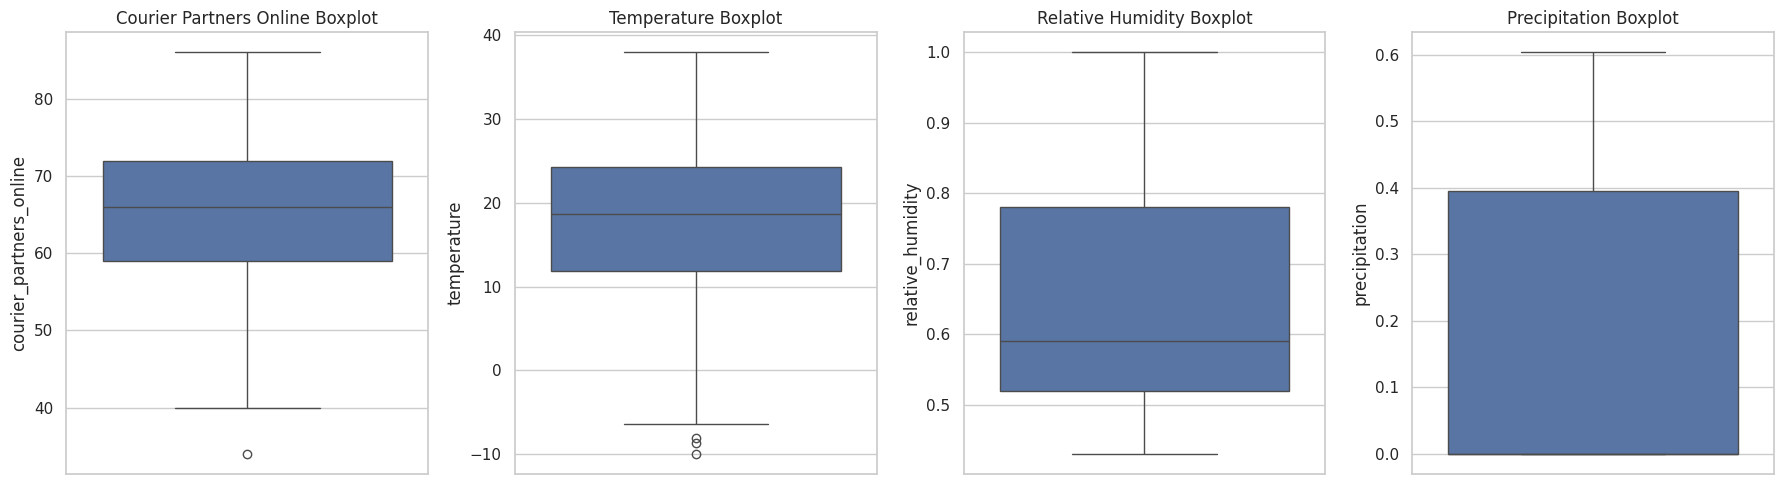

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Plot histograms for numerical features
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

sns.boxplot(data['courier_partners_online'], ax=axes[0])
axes[0].set_title('Courier Partners Online Boxplot')

sns.boxplot(data['temperature'], ax=axes[1])
axes[1].set_title('Temperature Boxplot')

sns.boxplot(data['relative_humidity'], ax=axes[2])
axes[2].set_title('Relative Humidity Boxplot')

sns.boxplot(data['precipitation'], ax=axes[3])
axes[3].set_title('Precipitation Boxplot')

plt.tight_layout()
plt.show()

**Courier Partners Online Boxplot:** There is a very low median value, with most of the data points clustered near zero. There are **several outliers** indicating instances where the number of courier partners online is significantly higher than usual. The interquartile range (IQR), which represents the middle 50% of the data, is very small, suggesting low variability for most of the time.

**Temperature Boxplot:** The median temperature is above 10 degrees, indicating that the central tendency of temperature is in the warmer range. The temperature has a wide spread as the IQR covers approximately 10 degrees to over 20 degrees. There are a **few outliers** on the low end, suggesting occasional cold temperature spikes.

**Relative Humidity Boxplot:** Relative humidity has a high median, close to 0.7 or 70%, indicating a generally humid condition.
The IQR is relatively narrow, showing that the relative humidity does not fluctuate widely for the most part. There are **no outliers**, which suggests that the relative humidity is consistent without extreme variations.

**Precipitation Boxplot:** The median precipitation is close to zero, which suggests that for a significant amount of time, there is no or very little precipitation. The IQR is very narrow, indicating that precipitation is usually low when it does occur.There is a **large number of outliers**, showing that heavy precipitation is not common but can occur.

## **3. Outlier Removal**

Fix or remove outliers and errors in your data to prevent them from negatively impacting your model.

In [ ]:
from scipy import stats

# Define a function to remove outliers using Z-score
def remove_outliers_zscore(X, z_threshold=3):
    z_scores = stats.zscore(X)
    X_no_outliers = X[(z_scores < z_threshold).all(axis=1)]
    return X_no_outliers

# Remove outliers from the data (replace 'X' with your dataset)
data = remove_outliers_zscore(data)

## **4. Multivariate Analysis**
Analysis involving multiple variables, useful for **exploring relationships** between two continuous variable

### **Scatter plot**

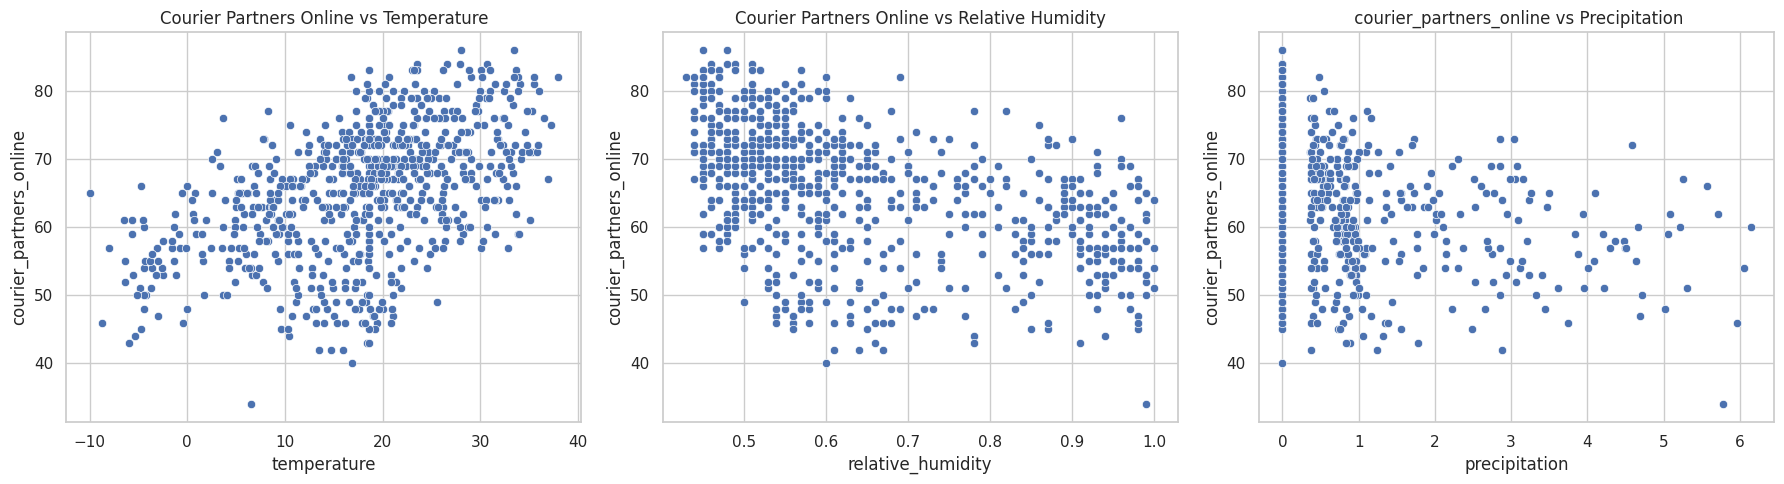

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Plot histograms for numerical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=data, x='temperature', y='courier_partners_online', ax=axes[0])
axes[0].set_title('Courier Partners Online vs Temperature')

sns.scatterplot(data=data, x='relative_humidity', y='courier_partners_online', ax=axes[1])
axes[1].set_title('Courier Partners Online vs Relative Humidity')

sns.scatterplot(data=data, x='precipitation', y='courier_partners_online', ax=axes[2])
axes[2].set_title(' courier_partners_online vs Precipitation')

plt.tight_layout()
plt.show()

**Insights**: The scatter plot does not show a clear relationship between these independent variables strong predictor in a model. and the number of courier partners online, suggesting it is necessary to perform other statistical analysis, like correlation coefficients to quantify the relationships shown in these plots.

### **Pair Plot**

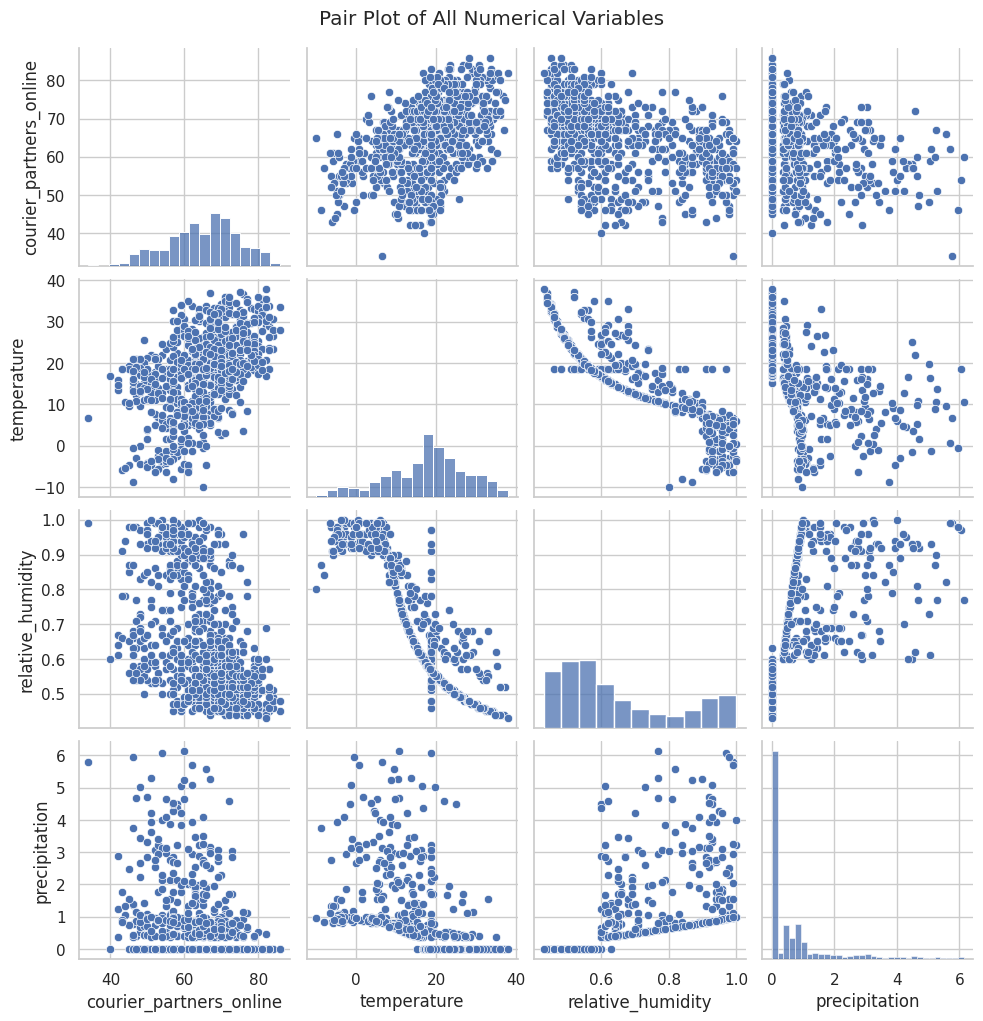

In [ ]:
sns.pairplot(data)
plt.suptitle('Pair Plot of All Numerical Variables', y=1.02)  # Adjust the title position
plt.show()

Against **temperature**, there's a large scatter with no clear trend suggesting that the number of courier partners online is **not strongly related** to temperature.

**Relative humidity** shows an interesting pattern; as humidity **increases**, the number of courier partners online seems to **decrease**, especially noticeable in higher humidity ranges.

**Precipitation** shows that the number of courier partners online tends to **decrease** as precipitation **increases**, which is more noticeable with higher amounts of precipitation.

## **5. Correlation Analysis**
Analysis only two variables, useful for **measuring strength and direction** of a linear relationship.

### **Heatmap**

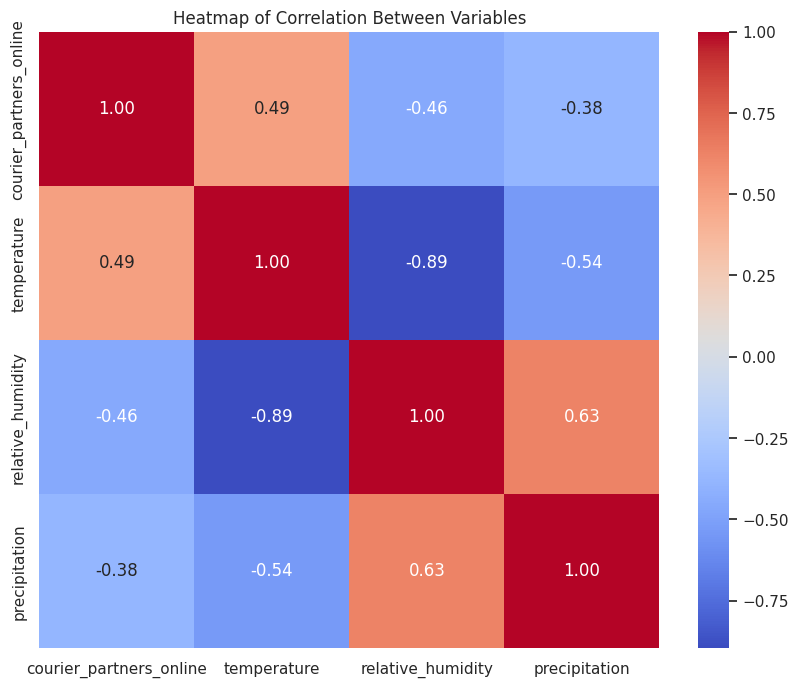

In [ ]:

# Heatmap of the correlations between numerical variables
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation Between Variables')
plt.show()

**Courier Partners Online and Temperature:** The correlation coefficient of 0.49 suggests a **moderate positive** relationship between temperature and the number of courier partners online. This could indicate that as temperatures rise, there might be an increase in the number of courier partners who are online.

**Courier Partners Online and Relative Humidity:** The correlation coefficient of -0.46 indicates a **moderate negative** relationship with relative humidity. This suggests that as relative humidity increases, the number of courier partners online tends to decrease.

**Courier Partners Online and Precipitation:** The correlation coefficient of -0.38 shows a **moderate negative** relationship with precipitation. This suggests that higher levels of precipitation might be associated with a decrease in the number of courier partners online.

## **6. Time Series Analysis**
Analysis of time-based variables, useful for measuring time range, frequency, trends, seasonality, and cyclic changes.

### **Time series Plot**

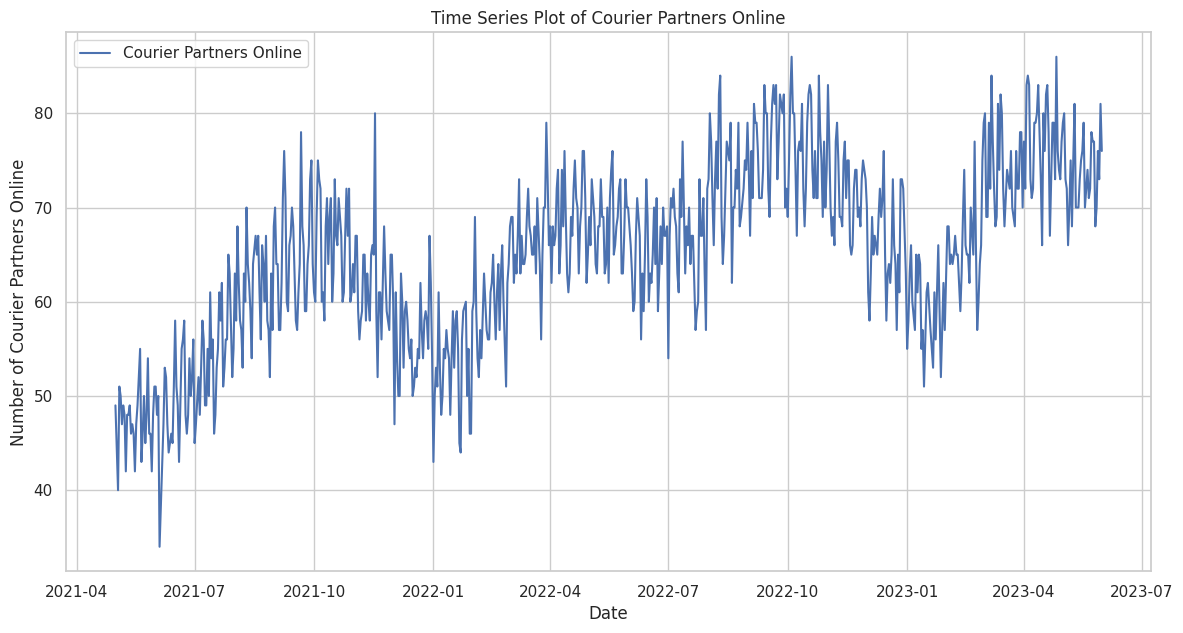

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['courier_partners_online'], label='Courier Partners Online')
plt.title('Time Series Plot of Courier Partners Online')
plt.xlabel('Date')
plt.ylabel('Number of Courier Partners Online')
plt.legend()
plt.show()

**Trend**: There appears to be a slight upward trend over time, suggesting that the number of courier partners online has been increasing gradually.

**Seasonality**: There are fluctuations that suggest potential seasonality or regular patterns in the data. However, without more specific context or a clearer pattern, it's difficult to definitively identify seasonal trends just from the plot.

**Volatility**: The number of courier partners online exhibits some volatility, with noticeable spikes and drops. This could be due to various factors such as market demand, weather conditions, special events, or promotions.

**Anomalies**: There are a few sharp peaks and troughs, which could represent anomalous days with an unusually high or low number of courier partners online. These could be outliers or could represent real events that caused the number to spike or drop.

**General Range:** The number of courier partners online typically ranges between approximately 40 to 80, with most of the data points falling in the middle of this range.

### **Time range and frequency**

In [ ]:
# Determine the overall time range of the dataset
time_range = data.index.max() - data.index.min()

# Determine the frequency of the data points by examining the difference between consecutive dates
date_diffs = data.index.to_series().diff().dt.days.value_counts().sort_index()

time_range, date_diffs

(Timedelta('760 days 00:00:00'),
 1.0    703
 2.0     27
 3.0      1
 Name: date, dtype: int64)

The dataset covers a **time range of 760 days**, with data points recorded daily (as indicated by the usual **1-day difference** between consecutive dates).

### **Trends, Seasons and Cyclic Changes**

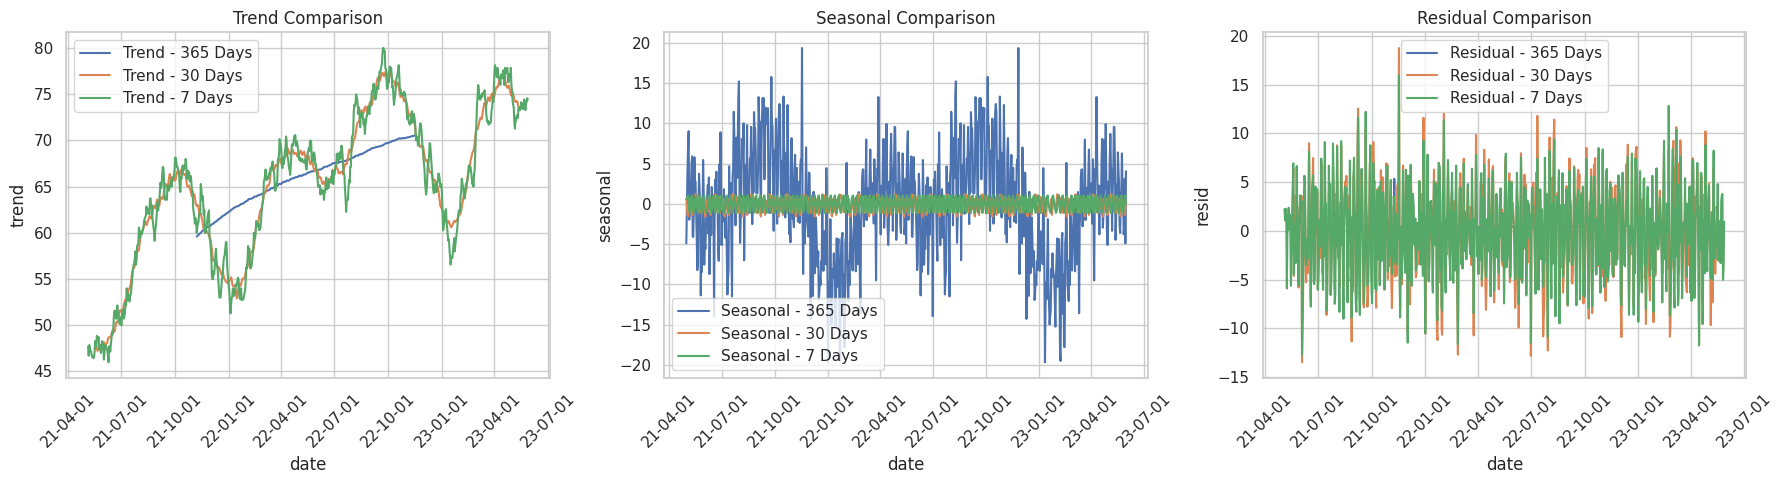

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Plot histograms for numerical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Decompose the time series with different periods
decomposition_365 = seasonal_decompose(data['courier_partners_online'], model='additive', period=365)
decomposition_30 = seasonal_decompose(data['courier_partners_online'], model='additive', period=30)
decomposition_7 = seasonal_decompose(data['courier_partners_online'], model='additive', period=7)

# Set the date format on the x-axis
date_format = mdates.DateFormatter('%y-%m-%d')
axes[0].xaxis.set_major_formatter(date_format)
axes[1].xaxis.set_major_formatter(date_format)
axes[2].xaxis.set_major_formatter(date_format)

plt.setp(axes[0].get_xticklabels(), rotation=45)
plt.setp(axes[1].get_xticklabels(), rotation=45)
plt.setp(axes[2].get_xticklabels(), rotation=45)

sns.lineplot(decomposition_365.trend, ax=axes[0], label='Trend - 365 Days')
sns.lineplot(decomposition_30.trend, ax=axes[0], label='Trend - 30 Days')
sns.lineplot(decomposition_7.trend, ax=axes[0], label='Trend - 7 Days')
axes[0].set_title('Trend Comparison')
axes[0].legend()

# Plotting the seasonal components together
sns.lineplot(decomposition_365.seasonal, ax=axes[1], label='Seasonal - 365 Days')
sns.lineplot(decomposition_30.seasonal, ax=axes[1], label='Seasonal - 30 Days')
sns.lineplot(decomposition_7.seasonal, ax=axes[1], label='Seasonal - 7 Days')
axes[1].set_title('Seasonal Comparison')
axes[1].legend()

# Plotting the residuals together
sns.lineplot(decomposition_365.resid, ax=axes[2], label='Residual - 365 Days')
sns.lineplot(decomposition_30.resid, ax=axes[2], label='Residual - 30 Days')
sns.lineplot(decomposition_7.resid, ax=axes[2], label='Residual - 7 Days')
axes[2].set_title('Residual Comparison')
axes[2].legend()

plt.tight_layout()
plt.show()

The graph represents three decomposed time series components from courier partners' activity data: trend, seasonal, and residual, using periods of 365, 30, and 7 days.

The **365-day trend** shows a smooth line, suggesting the long-term movement of the number of courier partners online, with an overall increasing trend.
The **30-day trend** is more responsive to changes, showing intermediate trends and cycles. The **7-day trend** is the most responsive, closely following the weekly fluctuations in the data.

The amplitude of the **seasonal** components seems most pronounced in the 7-day component, possibly indicating strong weekly seasonality as compared to 30-day and 365-day.

The **residuals** for the 365-day component show less variance than those for the 30-day and 7-day components, suggesting that the long-term trend captures more of the data's structure, leaving less unexplained noise.

### **Autocorrelations in the time series**

<Figure size 1200x600 with 0 Axes>

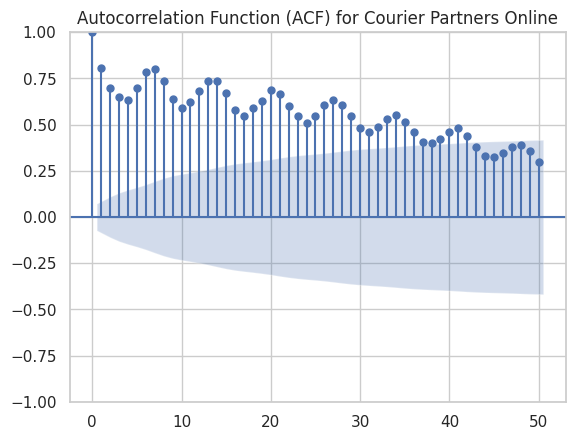

<Figure size 1200x600 with 0 Axes>

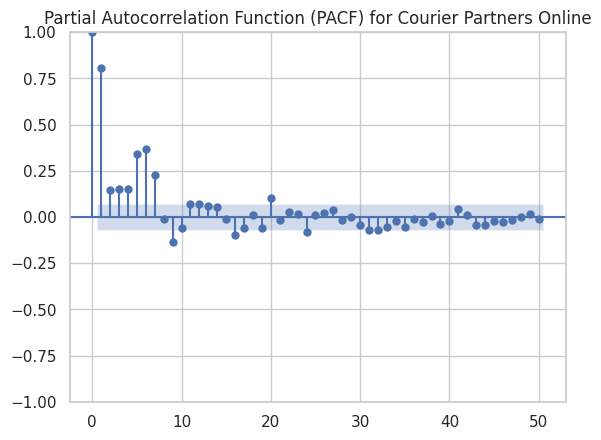

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(data['courier_partners_online'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) for Courier Partners Online')
plt.show()

# Plotting the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(data['courier_partners_online'], lags=50, alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) for Courier Partners Online')
plt.show()

**Slow Decay in ACF**: The ACF plot shows a slow decay without a clear cut-off, suggesting that the data might be non-stationary or that there is a long-term trend present.

**Seasonal Patterns in ACF**: The oscillation of autocorrelation values at regular intervals in the ACF plot indicates potential seasonality in the data.

**Sharp Drop in PACF**: The PACF plot shows a sharp drop after the first lag, which suggests that an autoregressive term of order 1 might be significant when modeling this time series.

**Insignificant Lags in PACF**: Most of the PACF values after the initial drop are within the confidence interval (close to zero), indicating that additional AR terms are likely not needed beyond the first lag.

**Model Selection**: The insights from the ACF and PACF suggest that a model with an AR term and differencing (to address non-stationarity and decay in ACF) might be appropriate, potentially an ARIMA(1,d,0) model where 'd' is determined by the level of differencing required to achieve stationarity. The seasonality suggested by the ACF plot might also necessitate a seasonal component in the model, such as a SARIMA model.

### **Stationarity**
Testing stationarity in the series

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(data['courier_partners_online'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.114393
p-value                          0.238766
#Lags Used                      19.000000
Number of Observations Used    712.000000
Critical Value (1%)             -3.439568
Critical Value (5%)             -2.865608
Critical Value (10%)            -2.568936
dtype: float64


The test statistic (-2.114393) is higher (less negative) than the critical values at the 1%, 5%, and 10% levels.

The p-value (0.238766) is quite high, indicating that there is a significant probability of observing such a test statistic if the null hypothesis of non-stationarity is true.

**This means that the series likely contains some form of trend or seasonality that should be addressed before using ARIMA or SARIMA models.**

# **Preprocessing**

**TLDR:** We standardize, remove skewness and improve stationarity.

**From our EDA,** we had the following findings for our preprocessing:

1. The courier partners online and precipitation has outliers. **(Removed during EDA)**
2. Precipitation requires the most skewness treatment.
3. Improve stationarity

## **1. Normalization/Standardization**

Since we are opting for **ARIMA**, **SARIMA** or **SARIMAX**, they are insensitive to variance as opposed to machine learning models.

## **2. Skewness**

Fix or remove outliers and errors in your data to prevent them from negatively impacting your model.

In [ ]:
# Apply a Box-Cox transformation on Precipitation
from scipy.stats import boxcox

data['precipitation'] += 1

data['precipitation'], _ = boxcox(data['precipitation'])

## **3. Seasonal Differencing**
Removing seasons to achieve stationarity in the series.



In [ ]:
# Seasonal differencing (e.g., for monthly data with yearly seasonality, use 12)
timeseries_diff = data['courier_partners_online'] - data['courier_partners_online'].shift(7)
timeseries_diff.dropna(inplace=True)

# Test stationarity again
test_stationarity(timeseries_diff)

timeseries_diff.shape

Results of Dickey-Fuller Test:
Test Statistic                -6.540687e+00
p-value                        9.363517e-09
#Lags Used                     2.000000e+01
Number of Observations Used    7.040000e+02
Critical Value (1%)           -3.439673e+00
Critical Value (5%)           -2.865654e+00
Critical Value (10%)          -2.568961e+00
dtype: float64


(725,)

# **Model Selection**

**Time Series Trends and Seasonality:**

* Presence of trends and seasonality suggests using ARIMA or SARIMA models, designed to handle such characteristics.
* A trend indicates the need for differencing or a model with a trend component.
* Seasonality indicates that a seasonal model (SARIMA) can capture periodic fluctuations.

**ACF and PACF Plots:**

* ACF plot has shown a gradual decline in correlation and seasonal patterns, showing through differencing and seasonal orders, it can be made suitable for ARIMA and SARIMA.
* PACF plot suggests starting with an AR(1) model.

**Distribution of Variables (Histograms):**

* Variable distributions exhibit skewness, especially in precipitation.
* We must consider data transformation before modeling; both ARIMA/SARIMA and ensemble models can benefit from this.

**Outliers and Noise:**

* We must address outliers and noise as ARIMA and SARIMA models are sensitive to them.
* Ensemble models may offer robustness to outliers in some cases though.

**Exogenous Variables:**

* Incorporate external predictors (e.g., temperature, humidity, precipitation) in an ARIMAX or SARIMAX model as an alternative to ARIMA/SARIMA.

**Verdict:**

* Given our data, ARIMA and SARIMA models seems the most suitable option since we are dealing with time series observations.
* These models explicitly model the temporal structure of time series data and can be customized based on ACF and PACF plot observations.

# **Model Training**

In [ ]:
split_point = int(len(data) * 0.8)

# Split the data
train = data[:split_point]
test = data[split_point:]

## **ARIMA Model**

In [ ]:
# ARIMA parameters
p = 1
d = 1
q = 1

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

model = SARIMAX(train['courier_partners_online'], order=(p, d, q))
arima_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## **SARIMA Model**

In [ ]:
# SARIMA parameters
P = 1
D = 1
Q = 1
s = 7

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

model = SARIMAX(train['courier_partners_online'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## **ARIMAX Model**

In [ ]:
exog_vars = ['temperature', 'relative_humidity', 'precipitation']

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

model = SARIMAX(train['courier_partners_online'], order=(p, d, q), exog=train[exog_vars])
arimax_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## **SARIMAX Model**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

model = SARIMAX(train['courier_partners_online'], order=(p, d, q), seasonal_order=(P, D, Q, s), exog=train[exog_vars])
sarimax_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# **Model Testing**

In [ ]:
days_to_predict = 10

In [ ]:
def get_model_forecast(model, days, exog=False):
  forecast = model.get_forecast(steps=days, exog= test[exog_vars][:days] if exog else None)
  actual_values = test['courier_partners_online'][:days]
  predicted_values = forecast.predicted_mean
  predicted_values.index = actual_values.index
  # errors
  mae = mean_absolute_error(actual_values, predicted_values)
  mse = mean_squared_error(actual_values, predicted_values)
  rmse = np.sqrt(mse)
  mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
  return {'mae': mae, 'mse': mse, 'rmse': rmse, 'mape': mape}

In [ ]:
arima_results = get_model_forecast(arima_model, days_to_predict, False)
sarima_results = get_model_forecast(sarima_model, days_to_predict, False)
arimax_results = get_model_forecast(arimax_model, days_to_predict, True)
sarimax_results = get_model_forecast(sarimax_model, days_to_predict, True)

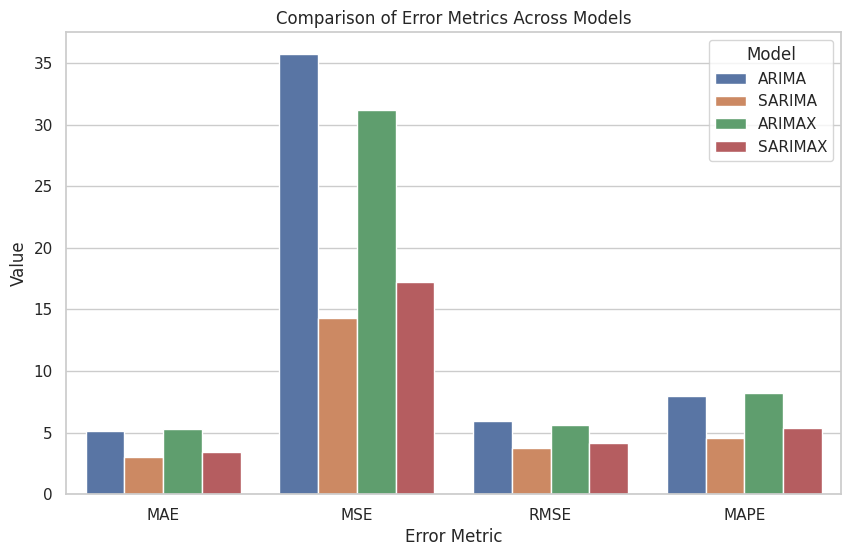

In [ ]:
data = {
    'Model': ['ARIMA', 'SARIMA', 'ARIMAX', 'SARIMAX'],
    'MAE': [arima_results['mae'], sarima_results['mae'], arimax_results['mae'], sarimax_results['mae']],
    'MSE': [arima_results['mse'], sarima_results['mse'], arimax_results['mse'], sarimax_results['mse']],
    'RMSE': [arima_results['rmse'], sarima_results['rmse'], arimax_results['rmse'], sarimax_results['rmse']],
    'MAPE': [arima_results['mape'], sarima_results['mape'], arimax_results['mape'], sarimax_results['mape']]
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame to have error metrics and their values in separate columns
df_melted = df.melt(id_vars=["Model"], var_name="Metric", value_name="Value")

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=df_melted)

# Add some customizations
plt.title('Comparison of Error Metrics Across Models')
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.legend(title='Model')

# Show the plot
plt.show()

# **Result**

Among the four tested models, **SARIMA and SARIMAX** seems to be the clear winners, indicating **seasonality** plays a crucial role improving forecasting results. Whereas when comparing models having **exogenouos variables**, they indicate a slight reduction in error.